# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Число клиентов перешедших на тариф "Ультра" в 2.26 раза меньше клиентов пользующихся архивными тарифами.

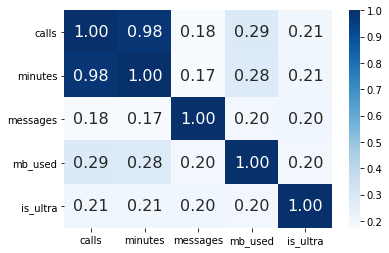

In [6]:
sns.heatmap(data.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16});

In [27]:
def get_VIF(data , target):
    X = add_constant(data.loc[:, data.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
    return seriesObject

target = 'calls'
get_VIF(data,target)

const       8.033289
minutes     1.125911
messages    1.082372
mb_used     1.130558
is_ultra    1.094845
dtype: float64

Пара минуты и звонки имеет признаки сильно-скоррелированных (мультиколлинеарных признаков). Столбец Calls содержит информацию о колличестве звонков, нам эта метрика не нужна, достаточно информации о колличестве минут. Удалим столбец Calls чтобы исключить влияние мультиколлинеарных признаков.

In [8]:
df = data.drop(['calls'], axis=1)

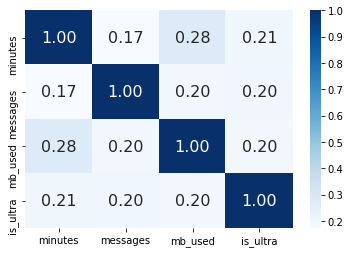

In [9]:
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt='.2f', annot_kws={'size':16});

## Разбейте данные на выборки

Обучающую выборка:

In [10]:
main_set, training_set = train_test_split(df, test_size=0.25, random_state=12345, stratify = df['is_ultra'])

In [11]:
features_main = main_set.drop(['is_ultra'], axis=1) # основная выборка
target_main = main_set['is_ultra'] # целевой признак

Уровень precision достаточно высок, значит модель делает много корректных предсказаний класса Positive.

In [12]:
features = training_set.drop(['is_ultra'], axis=1) # тренировочная выборка
target = training_set['is_ultra'] # целевой признак

Разобьем данные на валидационную и тестовую выборки:

In [13]:
features_test, features_valid, target_test, target_valid = train_test_split(
    features, target, test_size=0.5, random_state=12345, stratify = target)

## Исследуйте модели

### Решающее дерево:

In [14]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_main, target_main)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print(f'Глубина модели: {depth}; Качество модели: {best_result}.')

Глубина модели: 5; Качество модели: 0.8059701492537313.


### Случайный лес:

In [15]:
best_model = None
best_result = 0
for est in range(1, 21):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_main, target_main)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result

print(f'Качество модели: {best_result}. EST:{est}')

Качество модели: 0.8084577114427861. EST:20


#### Попробуем поменять гиперпараметры:

In [16]:
model = RandomForestClassifier(max_depth=22, random_state=12345, n_estimators=54)
model.fit(features_main, target_main)
result_1 = model.score(features_valid, target_valid)
print(f'Качество модели: {result_1}.')

Качество модели: 0.8059701492537313.


In [17]:
model = RandomForestClassifier(max_depth=2, random_state=12345, n_estimators=17)
model.fit(features_main, target_main)
result_2 = model.score(features_valid, target_valid)
print(f'Качество модели: {result_2}.')

Качество модели: 0.7686567164179104.


In [18]:
model = RandomForestClassifier(max_depth=18, random_state=12345, n_estimators=100)
model.fit(features_main, target_main)
result_3 = model.score(features_valid, target_valid)
print(f'Качество модели: {result_3}.')

Качество модели: 0.8233830845771144.


Чем выше гиперпараметр **n_estimators** тем выше качество модели а значения глубины дерева дают лучший результат в диапазоне от 8 до 20.

### Логистическая регрессия:

In [19]:
model = LogisticRegression()
model.fit(features_main, target_main)
result = model.score(features_valid, target_valid)
print(f'Качество модели: {result}.')

Качество модели: 0.7064676616915423.


В "Решающем лесу" качество модели лучше всего.

## Проверьте модель на тестовой выборке

### Решающее дерево:

In [20]:
model = DecisionTreeClassifier(max_depth=4, random_state=12345)
model.fit(features_main, target_main)
result_tree = model.score(features_test, target_test)       
print(f'Качество модели: {result_tree}.')

Качество модели: 0.7885572139303483.


### Случайный лес:

In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=20)
model.fit(features_main, target_main)
result_forest = model.score(features_test, target_test)
print(f'Качество модели: {result_forest}.')

Качество модели: 0.7885572139303483.


### Логистическая регрессия:

In [22]:
model = LogisticRegression()
model.fit(features_main, target_main)
result_logistic = model.score(features_test, target_test)
print(f'Качество модели: {result_logistic}.')

Качество модели: 0.7164179104477612.


При проверке на тестовой выборке, качество модели "решающего древа" <s>лучше чем в</s> и "случайном лесу" одинаковы.

## (бонус) Проверьте модели на адекватность

In [23]:
dc_mf = DummyClassifier(strategy="most_frequent") 
dc_mf.fit(features_main, target_main)
naive_forecast = dc_mf.score(features_test, target_test)
print(f'Наивный прогноз: {naive_forecast}. Наш прогноз: {result_forest}')

Наивный прогноз: 0.6940298507462687. Наш прогноз: 0.7885572139303483


In [24]:
dc_mf = DummyClassifier(strategy="prior") 
dc_mf.fit(features_main, target_main)
naive_forecast = dc_mf.score(features_test, target_test)
print(f'Наивный прогноз: {naive_forecast}. Наш прогноз: {result_forest}')

Наивный прогноз: 0.6940298507462687. Наш прогноз: 0.7885572139303483


In [25]:
dc_mf = DummyClassifier(strategy="stratified") 
dc_mf.fit(features_main, target_main)
naive_forecast = dc_mf.score(features_test, target_test)
print(f'Наивный прогноз: {naive_forecast}. Наш прогноз: {result_forest}')

Наивный прогноз: 0.5870646766169154. Наш прогноз: 0.7885572139303483


In [26]:
dc_mf = DummyClassifier(strategy="uniform") 
dc_mf.fit(features_main, target_main)
naive_forecast = dc_mf.score(features_test, target_test)
print(f'Наивный прогноз: {naive_forecast}. Наш прогноз: {result_forest}')

Наивный прогноз: 0.4900497512437811. Наш прогноз: 0.7885572139303483


Наша модель оказалась адекватнее константной.

***Выводы:***

* Мы проверили 3 модели(решащее дерево, случайный лес и логистическая модель)
* Наилучший параметр касчесва 0.7885572139303483
* удалось выяснить что с увеличением гиперпараметра **n_estimators** растет и качество модели
* Результаты проверки на адекватность считаю удовлетварительными(но это не точно).